In [1]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "myresource_id",
    location = "westeurope"
)

In [2]:
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.circuit.library import QFT
from numpy import pi
from qiskit.tools.monitor import job_monitor
from qiskit import transpile

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.qpu
- ionq.simulator
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s2-sim


In [3]:
def controlled_unitary(qc, qubits: list, phases: list): # x,y,z = Specific Qubit; a,b,c,d = Phases
    qc.cp(phases[2]-phases[0], qubits[0], qubits[1]) # controlled-U1(c-a)
    qc.p(phases[0], qubits[0]) # U1(a)
    qc.cp(phases[1]-phases[0], qubits[0], qubits[2]) # controlled-U1(b-a)
    
    # controlled controlled U1(d-c+a-b)
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp(-(phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[1], qubits[2])
    qc.cx(qubits[0], qubits[1])
    qc.cp((phases[3]-phases[2]+phases[0]-phases[1])/2, qubits[0], qubits[2])

In [4]:
def U(times, qc, unit, eigen, phases: list): # a,b,c = phases for U1; d,e,f = phases for U2; g,h,i = phases for U3; j,k,l = phases for U4; m_list=[m, n, o, p, q, r, s, t, u, a, b, c, d, e, f, g, h, i, j, k, l]
    controlled_unitary(qc, [unit[0]]+eigen[0:2], [0]+phases[0:3])
    controlled_unitary(qc, [unit[0]]+eigen[2:4], [phases[3]]+[0]+phases[4:6])
    controlled_unitary(qc, [unit[0]]+eigen[4:6], phases[6:8]+[0]+[phases[8]])
    controlled_unitary(qc, [unit[0]]+eigen[6:8], phases[9:12]+[0])

In [5]:
def final_U(times, eigen, phases: list):
    unit = QuantumRegister(1, 'unit')
    qc = QuantumCircuit(unit, eigen)
    for _ in range(2**times):
        U(times, qc, unit, eigen, phases)
    return qc.to_gate(label='U'+'_'+(str(2**times)))

In [6]:
# Storing the eigenvalues in a list
eigen_values = ["11000110", "10001101", "11001001", "10000111", "01001110", "01001011"]

# Function to place appropriate corresponding gate according to eigenstates
def eigenstates(qc, eigen, index):
    for i in range(0, len(eigen)):
        if eigen_values[index][i] == '1':
            qc.x(eigen[i])
        if eigen_values[index][i] == '0':
            pass
    qc.barrier()
    return qc


In [7]:
# Initialization
unit = QuantumRegister(6, 'unit')
eigen = QuantumRegister(8, 'eigen')
unit_classical = ClassicalRegister(6, 'unit_classical')
qc = QuantumCircuit(unit, eigen, unit_classical)
#

# Setting one eigenstate 
# In this case it has been chosen the first eigenstate i.e. 11000110 from eigen_values list.
eigenstates(qc, eigen, 0)
#

# Hadamard on the 'unit' qubits
qc.h(unit[:])
qc.barrier()
#

# Controlled Unitary  
phases = [pi / 2, pi / 8, pi / 4, pi / 2, pi / 4, pi / 4, pi / 8, pi / 4, pi / 8, pi / 4, pi / 4, pi / 8] # a, b, c, d, e, f, g, h, i, j, k, l
for i in range(0, 6):
    qc.append(final_U(i, eigen, phases), [unit[5-i]] + eigen[:])
#

# Inverse QFT 
qc.barrier()
qft = QFT(num_qubits=len(unit), inverse=True, insert_barriers=True, do_swaps=False, name='Inverse QFT')
qc.append(qft, qc.qubits[:len(unit)])
qc.barrier()
#

# Measure
qc.measure(unit, unit_classical)
#

# Draw
qc.draw()

░ ┌───┐ ░                                          »
          unit_0: ──────░─┤ H ├─░──────────────────────────────────────────»
                        ░ ├───┤ ░                                 ┌───────┐»
          unit_1: ──────░─┤ H ├─░─────────────────────────────────┤0      ├»
                        ░ ├───┤ ░                         ┌──────┐│       │»
          unit_2: ──────░─┤ H ├─░─────────────────────────┤0     ├┤       ├»
                        ░ ├───┤ ░                 ┌──────┐│      ││       │»
          unit_3: ──────░─┤ H ├─░─────────────────┤0     ├┤      ├┤       ├»
                        ░ ├───┤ ░         ┌──────┐│      ││      ││       │»
          unit_4: ──────░─┤ H ├─░─────────┤0     ├┤      ├┤      ├┤       ├»
                        ░ ├───┤ ░ ┌──────┐│      ││      ││      ││       │»
          unit_5: ──────░─┤ H ├─░─┤0     ├┤      ├┤      ├┤      ├┤       ├»
                  ┌───┐ ░ └───┘ ░ │      ││      ││      ││      ││       │»
         eigen_0: ┤ X ├─░───────░─┤1     ├┤1     ├┤1     ├┤1     ├┤1      ├»
                  ├───┤ ░       ░ │      ││      ││      ││      ││       │»
         eigen_1: ┤ X ├─░───────░─┤2     ├┤2     ├┤2     ├┤2     ├┤2 U_16 ├»
                  └───┘ ░       ░ │      ││      ││      ││  U_8 ││       │»
         eigen_2: ──────░───────░─┤3     ├┤3     ├┤3 U_4 ├┤3     ├┤3      ├»
                        ░       ░ │      ││  U_2 ││      ││      ││       │»
         eigen_3: ──────░───────░─┤4 U_1 ├┤4     ├┤4     ├┤4     ├┤4      ├»
                        ░       ░ │      ││      ││      ││      ││       │»
         eigen_4: ──────░───────░─┤5     ├┤5     ├┤5     ├┤5     ├┤5      ├»
                  ┌───┐ ░       ░ │      ││      ││      ││      ││       │»
         eigen_5: ┤ X ├─░───────░─┤6     ├┤6     ├┤6     ├┤6     ├┤6      ├»
                  ├───┤ ░       ░ │      ││      ││      ││      ││       │»
         eigen_6: ┤ X ├─░───────░─┤7     ├┤7     ├┤7     ├┤7     ├┤7      ├»
                  └───┘ ░       ░ │      ││      ││      ││      ││       │»
         eigen_7: ──────░───────░─┤8     ├┤8     ├┤8     ├┤8     ├┤8      ├»
                        ░       ░ └──────┘└──────┘└──────┘└──────┘└───────┘»
unit_classical: 6/═════════════════════════════════════════════════════════»
                                                                           »
«                  ┌───────┐ ░ ┌──────────────┐ ░ ┌─┐               
«          unit_0: ┤0      ├─░─┤0             ├─░─┤M├───────────────
«                  │       │ ░ │              │ ░ └╥┘┌─┐            
«          unit_1: ┤       ├─░─┤1             ├─░──╫─┤M├────────────
«                  │       │ ░ │              │ ░  ║ └╥┘┌─┐         
«          unit_2: ┤       ├─░─┤2             ├─░──╫──╫─┤M├─────────
«                  │       │ ░ │  Inverse QFT │ ░  ║  ║ └╥┘┌─┐      
«          unit_3: ┤       ├─░─┤3             ├─░──╫──╫──╫─┤M├──────
«                  │       │ ░ │              │ ░  ║  ║  ║ └╥┘┌─┐   
«          unit_4: ┤       ├─░─┤4             ├─░──╫──╫──╫──╫─┤M├───
«                  │       │ ░ │              │ ░  ║  ║  ║  ║ └╥┘┌─┐
«          unit_5: ┤       ├─░─┤5             ├─░──╫──╫──╫──╫──╫─┤M├
«                  │       │ ░ └──────────────┘ ░  ║  ║  ║  ║  ║ └╥┘
«         eigen_0: ┤1      ├─░──────────────────░──╫──╫──╫──╫──╫──╫─
«                  │  U_32 │ ░                  ░  ║  ║  ║  ║  ║  ║ 
«         eigen_1: ┤2      ├─░──────────────────░──╫──╫──╫──╫──╫──╫─
«                  │       │ ░                  ░  ║  ║  ║  ║  ║  ║ 
«         eigen_2: ┤3      ├─░──────────────────░──╫──╫──╫──╫──╫──╫─
«                  │       │ ░                  ░  ║  ║  ║  ║  ║  ║ 
«         eigen_3: ┤4      ├─░──────────────────░──╫──╫──╫──╫──╫──╫─
«                  │       │ ░                  ░  ║  ║  ║  ║  ║  ║ 
«         eigen_4: ┤5      ├─░──────────────────░──╫──╫──╫──╫──╫──╫─
«                  │       │ ░                  ░  ║  ║  ║  ║  ║  ║ 
«         eigen_5: ┤6      ├─░──────────────────░─

In [11]:
from qiskit import transpile
#   Note that any target you have enabled in this workspace can
#   be used here. Azure Quantum makes it extremely easy to submit
#   the same quantum program to different providers. 
ionq_backend = provider.get_backend("ionq.qpu")
job = ionq_backend.run(transpile(qc, ionq_backend), shots=8192)
print("Job id:", job.id())

Job id: 92874b76-23fd-11ed-a100-00155d5ef23b


Job Status: job has successfully run


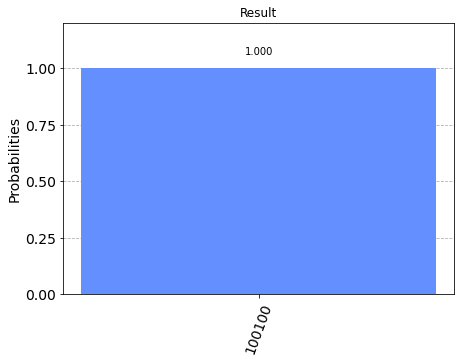

In [12]:
job_monitor(job)

result = job.result()

# The result object is native to the Qiskit package, so we can use Qiskit's tools to print the result as a histogram.
plot_histogram(result.get_counts(qc), title="Result")

In [15]:
backend = provider.get_backend("quantinuum.hqs-lt-s1")
cost = backend.estimate_cost(transpile(qc, ionq_backend), shots=100)
print(f"Estimated cost: {cost.estimated_total} {cost.currency_code}")

Estimated cost: 53.98499999999999 USD
